### A very simplistic closing FX prediction pipeline

I will first present a simplistic but classical statistics time series model -- the ARIMA model, using STATSMODELS, to predict the closing FX. On the other hand, a neural network approach with PyTorch will be demonstrated. These models will be applied with certain assumptions, which can be relaxed without much effort in reality. 

Python will be used instead of <code>R</code> for this piece of assignment.

The functions written are task-specific.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [9]:
eur_usd = pd.read_csv('EURUSD.csv')
n = len(eur_usd)
n2 = round(n/6)
n1 = n - n2
print(eur_usd.isnull().any())
op, cl = eur_usd['Open'][:-n2].values, eur_usd['Close'][:-n2].values
high, low = eur_usd['High'][:-n2].values, eur_usd['Low'][:-n2].values
print('model: {}; test: {}'.format(n1, n2))

Date           False
Time           False
Open           False
High           False
Low            False
Close          False
Tick volume    False
dtype: bool
model: 1326; test: 265


In [10]:
print(np.isnan(sum(cl)))

False


Each series is of length $1591$. One-sixth ($265/1591$) of the data is used for modelling and I will evaluate the model using in-samples.

Although <code>high</code> and <code>low</code> are extracted for completeness, they are no intended for modelling since in reality, they are not realized until a session is closed. It is not unusally for an index to close at its day-high or day-low; moreover, there is no such thing as a "close" for currency markets as they are traded around the clock (except over the weekends).

As the model is meant to predict short term closing rates, I will neglect the effect of both interday and intraday seasonalities. Indeed, a number of researches show that seasonality effects have been gradually diminshing, including the EUR/USD pair which demonstrated some until the early 1990s.

I verify that there are no missing or NAN values by applying the logic <code>NAN</code> $+x \equiv$ <code>NAN</code>. Since time series are indexed, if a particular $X_k$ is missing, the separated time series cannot be concatenated for model building as the data structure is damaged.

(-2.0839496744248605, 0.25101730074230366, 2, 1323, {'1%': -3.4353024060562674, '5%': -2.863727092349239, '10%': -2.5679344166325304}, -12534.014360204827)


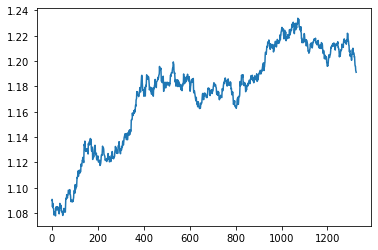

In [12]:
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(cl)
print(stationarity)
plt.plot(cl)

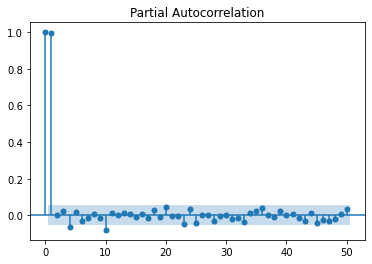

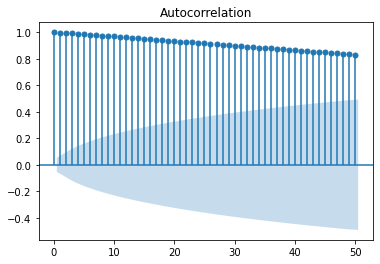

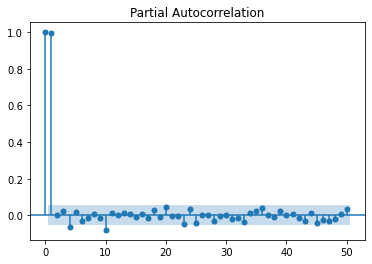

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(cl, lags=50, alpha=0.05)
plot_pacf(cl, lags=50, alpha=0.05)

The series plot and Adfuller test result both show that $X_t$ is highly non-stationary. On the other hand, a clear decay pattern in the autocorrelation plot probably suppresses the existence of MA components. Nevertheless, I will try to fit $X_t$ to $ARIMA(p,d,q)$ with several combinations of $(p,d,q)$. It is sensible for the candidates of $p$ to include p up to a big integer (maybe 10, for example) since closing prices have strong short term serial correlations.

For exploration I will split the time series $X_t$ to a trend $T_t$ and a noise $Z_t$. After having technical problems during the import of <code>tsa.seasonal</code> and turned to <b>R</b> trying out <code>TTR</code> (but failed as well), I will do smoothing <code>SMA</code> manually:

$$T_t \triangleq \frac{1}{2s+1} \sum_{k=-s}^s X_{t+k}$$ 

with $s$ chosen to be $3$ to represent a day trend such that $Z_t \triangleq X_t - T_t$.

In [15]:
T, Z = [], []
s = 3
t = s
while not t + s >= n1:
    T.append((1/(2*s+1))*np.sum(cl[t-s: t+s+1]))
    Z.append(cl[t] - T[t-s])
    t = t+1       

To check that $X_t = T_t + Z_t$ for $s \leq t \leq n_1 - s$.

In [16]:
print(max(abs(cl[s:n1-s] - (np.array(T) + np.array(Z)))))

0.0


I had a quick review on the properties of $Z_t$.

Shapiro: 0.00020704782218672335, D'Agostino's: 0.0002461264573083513


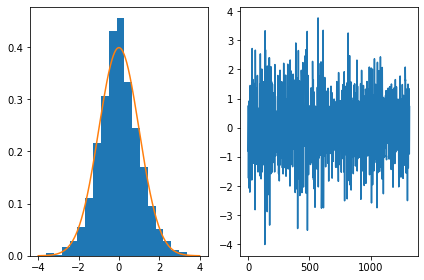

In [17]:
import scipy.stats as stats
lin = np.linspace(-4, 4, 1000)
ZZ = (Z - np.mean(Z))/np.std(Z)
fig, ax = plt.subplots(1, 2, sharey=False, tight_layout=True)
ax[0].hist(ZZ, bins=20, density=True)
ax[0].plot(lin, stats.norm.pdf(lin, 0, 1))
ax[1].plot(ZZ)
shap, ps = stats.shapiro(ZZ)
norm, pn = stats.normaltest(ZZ)
print('Shapiro: {}, D\'Agostino\'s: {}'.format(ps, pn))

Although the density and residual plots are very much like normal density and white noise plots, $Z_t$ cannot pass the respective normality tests with a satisfying $p$-value probably due to heavy sample tails.

Though, I will go on and try out fitting the time series models to see their performances. A simple grid search will be carried out on the parameter space. The performance of the respective models are given by the RMSE of the 1-step predictions: for a particular model $ARIMA(p,d,q)$ and given $\{X_t\}_{t=1}^{n_1}$, $X_{n_1+k}$ will be forecasted iteratively with constantly updated ARMA coefficients. The forecast window 


In [39]:
import itertools
from sklearn.metrics import mean_squared_error as mse

def pdq_list(pmin: int, pmax: int, pstep: int, dmin: int, dmax: int, dstep: int, qmin: int, qmax: int, qstep: int):
    p = range(pmin, pmax, pstep)
    d = range(dmin, dmax, dstep)
    q = range(qmin, qmax, qstep)
    pdq_list = list(itertools.product(p, d, q))
    return pdq_list

cl_t = eur_usd['Close'].values[n1:n1+20]

def evaluate(window, pdq_grid, alpha=0.05):
    errors = []
    for param in pdq_grid:
        history_r = cl
        history_p = cl
        for t in range(len(cl_t)):
            model = sm.tsa.arima.ARIMA(history_r, order=param)
            fit = model.fit(method='statespace')
            pred = fit.forecast(1, alpha=0.05)
            history_p = np.append(history_p, pred)
            history_r = np.append(history_r, [cl_t[t]])
        errors.append([param, mse(history_r[n1:], history_p[n1:], squared=False)])
    return errors


In [20]:
pdq_grid = pdq_list(1, 11, 2, 0, 2, 1, 0, 2, 1)
errors6 = evaluate(6, pdq_grid, 0.05)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Lik

In [21]:
errors6

[[(1, 0, 0), 0.001903870514872433],
 [(1, 0, 1), 0.0019039707284372904],
 [(1, 1, 0), 0.0019047145557939517],
 [(1, 1, 1), 0.0019037894549504772],
 [(3, 0, 0), 0.0018852289190080548],
 [(3, 0, 1), 0.001876935668818893],
 [(3, 1, 0), 0.0018820845864644452],
 [(3, 1, 1), 0.001882073232736121],
 [(5, 0, 0), 0.00188420456667954],
 [(5, 0, 1), 0.001874309609471146],
 [(5, 1, 0), 0.0018820388101873193],
 [(5, 1, 1), 0.001882804137601321],
 [(7, 0, 0), 0.001882986436131491],
 [(7, 0, 1), 0.0018725971380890026],
 [(7, 1, 0), 0.0018935637602502736],
 [(7, 1, 1), 0.001892884396597857],
 [(9, 0, 0), 0.0018762345416199191],
 [(9, 0, 1), 0.001868163303983171],
 [(9, 1, 0), 0.0018525000152416818],
 [(9, 1, 1), 0.0018525245011979758]]

In [ ]:
pdq_grid2 = pdq_list(11, 17, 2, 0, 2, 1, 0, 2, 1)
errors62 = evaluate(6, pdq_grid2, 0.05)

In [406]:
np.vstack((errors6, errors62))

array([[(1, 0, 0), 0.001903870514872433],
       [(1, 0, 1), 0.0019039707284372904],
       [(1, 1, 0), 0.0019047145557939517],
       [(1, 1, 1), 0.0019037894549504772],
       [(3, 0, 0), 0.0018852289190080548],
       [(3, 0, 1), 0.001876935668818893],
       [(3, 1, 0), 0.0018820845864644452],
       [(3, 1, 1), 0.001882073232736121],
       [(5, 0, 0), 0.00188420456667954],
       [(5, 0, 1), 0.001874309609471146],
       [(5, 1, 0), 0.0018820388101873193],
       [(5, 1, 1), 0.001882804137601321],
       [(7, 0, 0), 0.001882986436131491],
       [(7, 0, 1), 0.0018725971380890026],
       [(7, 1, 0), 0.0018935637602502736],
       [(7, 1, 1), 0.001892884396597857],
       [(9, 0, 0), 0.0018762345416199191],
       [(9, 0, 1), 0.001868163303983171],
       [(9, 1, 0), 0.0018525000152416818],
       [(9, 1, 1), 0.0018525245011979758],
       [(11, 0, 0), 0.0018511333122577705],
       [(11, 0, 1), 0.0018461588895851086],
       [(11, 1, 0), 0.001850989435086252],
       [(11, 1, 1),

As the RMSE displays a decreasing trend as $p$ increases from $1$ to $9$ (although different combinations of $d$ and $q$ makes it slightly jumpy), I decide verify how far this trend actually extends. As expected, the model performance does not actually improve significantly when $p$ exceeds 11. In other words, serial correlation is maintained within a window of only 2 days. This does not overrule our intuition in a sense that, for assets associated with very frequent price actions, "very old" financial data can be regarded as irrelevant or noise to the analysis of recent or future data. Indeed, EUR/USD is one of the 7 major currency pairs in the financial market. With the aid of the PACF plot above showing a partial correlation at around a 10-step lag, it is naively reasonable to make such a conclusion.

Next, I will narrow down the scope of parameters and go on a cross-validation procedure. Based on the interim results, I will fix $(d,q) = (0,1)$ and vary $p$ from $10$ to $13$.

In [ ]:
pdq_list3 = pdq_list(10, 14, 1, 0, 1, 1, 1, 2, 1)

Time series distinguish themselves with other data types by their indexing (or ordering). Shuffling time series is an illegal method as it destroys the information structure. Therefore, the cross-validation uses an increasing subsequence $\{X_t\}_{t=1}^{d_{k}} \subseteq \{X_t\}_{t=1}^{d_{k+1}}$ as training data.

In [24]:
from sklearn.model_selection import TimeSeriesSplit

def crossval(p, d, q, data, fold, window):
    tss = TimeSeriesSplit(n_splits=fold, test_size=window, gap=0)
    error = 0
    for tr_in, te_in in tss.split(data):
        train, test = cl[tr_in], cl[te_in]
        model = sm.tsa.arima.ARIMA(train, order=(p,d,q))
        fit = model.fit(method='statespace')
        pred = fit.forecast(window, alpha=0.05)
        error += mse(test, pred, squared=False)/fold
    return error

In [28]:
val_err = []
for p in np.arange(10,14,1):
    err = crossval(p, 0, 1, cl, 6, 6)
    val_err.append([(p,0,1), err])

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
val_err

[[(10, 0, 1), 0.003844024820029913],
 [(11, 0, 1), 0.0038590596002773],
 [(12, 0, 1), 0.003855241558415585],
 [(13, 0, 1), 0.003832185596500069]]

In this connection, the $ARIMA(13,0,1)$ will be selected.
We will try to do a 1-day forecast with such a model.

In [32]:
pred_model = sm.tsa.arima.ARIMA(cl, order=(13,0,1))
pred_fit = pred_model.fit(method='statespace')
pred_1d = pred_fit.forecast(6, alpha=0.05)

ValueError: expected '}' before end of string

pred_error: 0.0030570188559426482


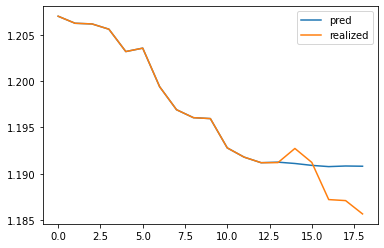

In [42]:
print('pred_error: {}'.format(mse(pred_1d, cl_t[0:6], squared=False)))
plt.plot(np.hstack((cl[-13:], pred_1d)), label='pred')
plt.plot(np.hstack((cl[-13:], cl_t[0:6])), label='realized')
plt.legend()

In [44]:
print(np.vstack((pred_1d, cl_t[0:6])))

[[1.19124803 1.19110469 1.19090034 1.19076638 1.19083196 1.19080798]
 [1.1912     1.19273    1.19122    1.1872     1.18709    1.18565   ]]


In [47]:
cl_gbp = pd.read_csv('GBPUSD.csv')['Close'].values
cl_gbp_train = cl_gbp[:n1]
cl_gbp_test = cl_gbp[n1:n1+6]
pred_model_gu = sm.tsa.arima.ARIMA(cl_gbp_train, order=(13,0,1))
pred_fit_gu = pred_model_gu.fit(method='statespace')
pred_1d_gu = pred_fit_gu.forecast(6, alpha=0.05)

pred_error: 0.0017323603821048086


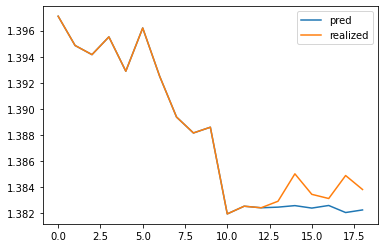

In [48]:
print('pred_error: {}'.format(mse(pred_1d_gu, cl_gbp_test, squared=False)))
plt.plot(np.hstack((cl_gbp_train[-13:], pred_1d_gu)), label='pred')
plt.plot(np.hstack((cl_gbp_train[-13:], cl_gbp_test)), label='realized')
plt.legend()

As the EUR/USD and GBP/USD pairs are shown to have strong correlations over the time compared to other major currency pairs, I applied the same model (with its own parameters) to GBP/USD. Results indicate that the errors of 1-day predictions to these currency pairs are 0.3% and 0.1% on average. This is around satisfactory given that no other quantified social factors and economic data are fed into the model. Moreover, time series work only for short term predictions. It is common for time series to perform badly while giving out-of-sample prediction. 

I will also try to do 1-day predict using a simple neural network. 

In [175]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class pred(nn.Module):
    def __init__(self):
        super(pred, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

nnfx = pred()

In [188]:
def train(data, model, loss_fn, optimizer):
    for i in range(len(data)):
        pred = model(data[i]['X'])
        loss = loss_fn(pred, data[i]['y'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('loss: {:8f}, trained: {:4d}/{:4d}'.format(loss, i, len(data)))
    
def test(data, model, loss_fn):
    with torch.no_grad():
        err = 0
        for i in range(len(data)):
            pred = model(data[i]['X'])
            loss = loss_fn(pred, data[i]['y'])
            err += loss/len(data)
        print('Error: {}'.format(err))
    return err

After creating a simple neural network pipeline, I need to prepare properly formatted data. Same as the above time series, I will pick a subseries of length 13 to predict the next six close prices.

In the train-test-split, we need to be aware of the size of the test samples. Since the time series terminates somewhere, the incomplete test samples will be excluded.

In [195]:
def create_data(X, train_ratio = 0.8):
    n_train = round(len(X) * train_ratio)
    train_data, test_data = [], []
    for i in range(n_train):
        train_data.append({'X': torch.tensor(X[i: i+13]), 'y': torch.tensor(X[i+13: i+19])})
    for i in range(n_train, len(X), 1):
        if len(X[i+13: i+19]) == 6:
            break
        test_data.append(({'X': torch.tensor(X[i: i+13]), 'y': torch.tensor(X[i+13: i+19])}))
    return train_data, test_data  

In [196]:
train_data, test_data = create_data(eur_usd['Close'].values, train_ratio = 0.8)

In [193]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnfx.parameters(), lr=0.1)
epochs = 10

nnfx = nnfx.double()
nnfx.train()
nnfx.reset_parameters()

for k in range(epochs):
    print('Epoch {}'.format(k+1))
    train(train_data, nnfx, loss_fn, optimizer)

Epoch 1
loss: 1.174005, trained:    0/1273
loss: 0.000032, trained:  100/1273
loss: 0.000004, trained:  200/1273
loss: 0.000003, trained:  300/1273
loss: 0.000014, trained:  400/1273
loss: 0.000028, trained:  500/1273
loss: 0.000101, trained:  600/1273
loss: 0.000001, trained:  700/1273
loss: 0.000061, trained:  800/1273
loss: 0.000008, trained:  900/1273
loss: 0.000074, trained: 1000/1273
loss: 0.000046, trained: 1100/1273
loss: 0.000002, trained: 1200/1273
Epoch 2
loss: 0.018919, trained:    0/1273
loss: 0.000018, trained:  100/1273
loss: 0.000048, trained:  200/1273
loss: 0.000035, trained:  300/1273
loss: 0.000041, trained:  400/1273
loss: 0.000013, trained:  500/1273
loss: 0.000019, trained:  600/1273
loss: 0.000003, trained:  700/1273
loss: 0.000019, trained:  800/1273
loss: 0.000009, trained:  900/1273
loss: 0.000066, trained: 1000/1273
loss: 0.000007, trained: 1100/1273
loss: 0.000024, trained: 1200/1273
Epoch 3
loss: 0.018767, trained:    0/1273
loss: 0.000005, trained:  100/1

In [204]:
mse_nn = test(test_data, nnfx, loss_fn)

Error: 0.0008287790341018921


In [207]:
print('MSE for ARIMA: {}'.format(mse(pred_1d_gu, cl_gbp_test, squared=True)))

MSE for ARIMA: 3.0010724934863185e-06


C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


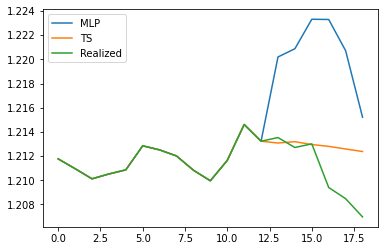

In [258]:
import numpy.random as random
z = random.randint(1000, 1200)
comts = sm.tsa.arima.ARIMA(cl[0:z], order=(13,0,1))
comts_fit = comts.fit(method='statespace')
comts_pred = comts_fit.forecast(6, alpha=0.05)
comnn = nnfx(train_data[z]['X']).detach().numpy()

plt.plot(np.hstack((cl[z-13: z], comnn)), label='MLP')
plt.plot(np.hstack((cl[z-13: z], comts_pred)), label='TS')
plt.plot(cl[z-13: z+6], label='Realized')
plt.legend()
plt.show()


Randomly selected realizations of the $ARIMA(13,0,1)$ and the MLP are shown. In general, the MLP has displayed a greater error than the time series model, which may mean its variance is larger.

I have displayed two models for FX predictions without taking into account any other figures. Although they seem to be naive, and they actually are, I regard this as a good chance to review my knowledge as gain more insights about FX predictions (like the phenomenon of diminshing FX seasonalities and some sort of frequently used sophisticated FX model).

I thank you very much for studying the entire notebook closely. I admit some parts of it may be rather confusing. I would we would have a chance to meet later, if not now.

I wish you doing good in the new year.

-- Houston Tang, Applicant